# 강화 학습 (Reinforcement learning) 2

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

## Q learning : Frozenlake

In [6]:
def rargmax(vector):
    m = np.amax(vector)
    indices = np.nonzero(vector == m)[0]
    return random.choice(indices)

In [5]:
env = gym.make("FrozenLake-v1", desc = None,
               map_name = "4x4", is_slippery = True)

num_state = env.observation_space.n
num_actions = env.action_space.n 

In [7]:
## Q TABLE
Q = np.zeros([num_state, num_actions])
num_episodes = 10000
gamma = 0.95
lr = 0.2 # learning rate
# e = 0.2

100%|██████████| 10000/10000 [00:14<00:00, 694.45it/s]


Success rate =  0.5627
Q Table
[[0 3 1 3]
 [0 0 2 0]
 [3 1 0 0]
 [0 2 1 0]]


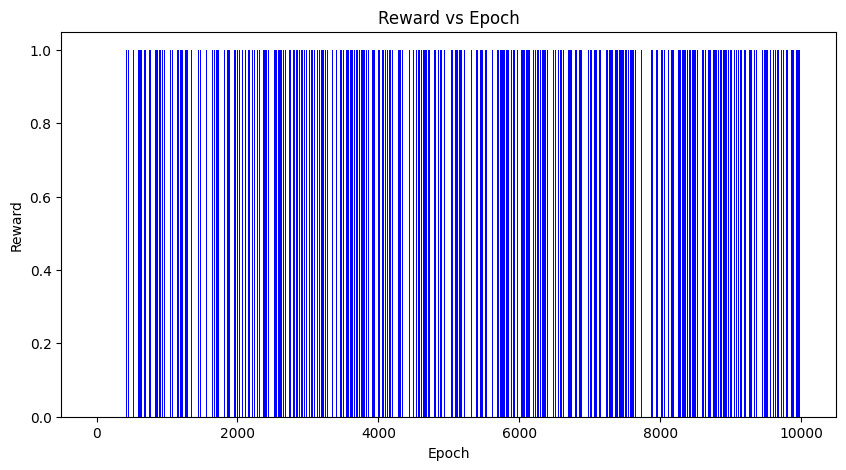

In [8]:
rList = []
for i in tqdm(range(num_episodes)):
    s, _ = env.reset() # (0, {})

    rALL = 0
    terminated = False
    e = 1/((i/50) + 1)

    while not terminated:
             
        if np.random.rand(1) < e:
            action = env.action_space.sample()
        else:
            action = rargmax(Q[s, :])

        s_, reward, terminated, truncated, _ = env.step(action)
        Q[s, action] = (1-lr)*Q[s, action] + lr*(reward + gamma*np.max(Q[s_, :]))

        rALL += reward

        s = s_
    rList.append(rALL)

print("Success rate = ", sum(rList)/num_episodes)

print("Q Table")
# print(Q)
print(np.argmax(Q, axis = 1).reshape(4, 4))


plt.figure(figsize = (10, 5))
plt.bar(range(len(rList)), rList, color = "b")
plt.xlabel("Epoch")
plt.ylabel('Reward')
# plt.xlim(1900, 2000)
plt.title("Reward vs Epoch")
plt.show()


## Q learning : Taxi

In [11]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import time
import os

최근 100 episode 평균 score = -623.0, 평균 step = 200.0
최근 100 episode 평균 score = -322.72, 평균 step = 146.32
최근 100 episode 평균 score = -44.14, 평균 step = 47.59
최근 100 episode 평균 score = -7.3, 평균 step = 22.45
최근 100 episode 평균 score = 0.04, 평균 step = 16.55
최근 100 episode 평균 score = 0.29, 평균 step = 15.85
최근 100 episode 평균 score = 1.98, 평균 step = 15.6
최근 100 episode 평균 score = 1.2, 평균 step = 14.85
최근 100 episode 평균 score = 1.25, 평균 step = 15.52
최근 100 episode 평균 score = 1.8, 평균 step = 14.97


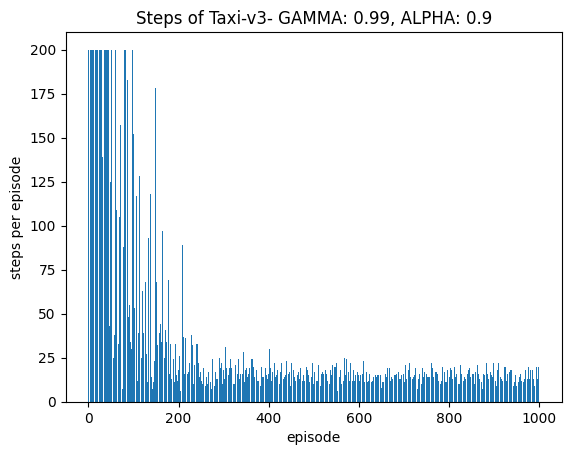

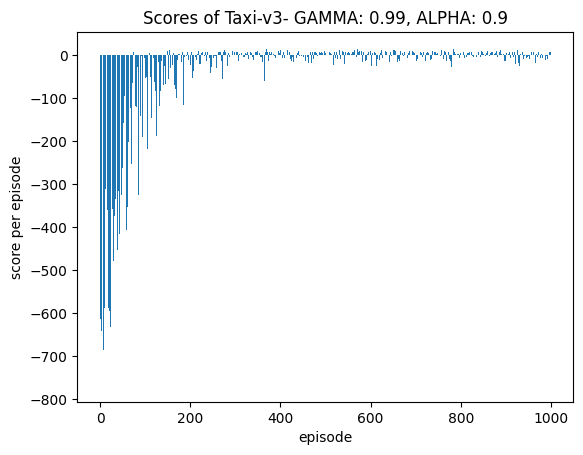

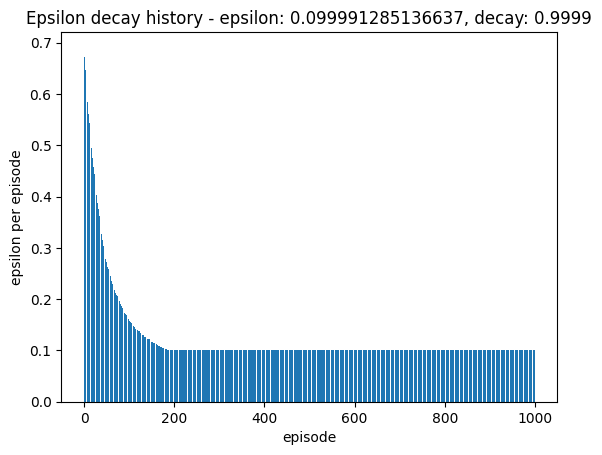

In [12]:
"""
6개의 이산적인 결정적 행동:
    - 0: 남쪽으로 이동
    - 1: 북쪽으로 이동
    - 2: 동쪽으로 이동
    - 3: 서쪽으로 이동
    - 4: 승객 탑승
    - 5: 승객 하차
    
상태 공간은 다음과 같이 표현됩니다:
        (택시_행, 택시_열, 승객_위치, 목적지)
          5 * 5 * 5 * 4 = 500

보상:
    스텝당: -1,
    승객을 목적지에 배달: +20,
    "pickup"과 "drop-off" 행동을 불법적으로 실행: -10
    
파란색: 승객
자홍색: 목적지
노란색: 빈 택시
녹색: 가득 찬 택시
"""
env = gym.make('Taxi-v3')
n_states = env.observation_space.n  # 500
n_actions = env.action_space.n      # 6

# 알고리즘의 파라미터 설정: 스텝 사이즈 alpha (0, 1], 0 보다 큰 작은 탐색률 e 
GAMMA = 0.99  # time decay
ALPHA = 0.9  # learning rate
epsilon = 0.7 # exploration start
epsilon_final = 0.1
epsilon_decay = 0.9999

# Q(s,a)를 초기화
Q = defaultdict(lambda: np.zeros(n_actions))

n_episodes = 1000

scores = []  # agent 가 episode 별로 얻은 score 기록
steps = []  # agent 가 episode 별로 목표를 찾아간 step 수 변화 기록
greedy = [] # epsilon decay history 기록

#Loop for each episode:
for episode in range(n_episodes):
    if episode > n_episodes * 0.995:
        env = gym.make('Taxi-v3', render_mode="human")
    # 에피소드를 초기화
    s, _ = env.reset()
    step = 0
    score = 0
    # 각 에피소드의 각 스텝에 대한 반복문
    while True:
        step += 1
        # Q에서 유도된 정책(예: e-greedy)을 사용하여 S에서 A를 선택
        # 행동 정책 : e-greedy
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = np.argmax(Q[s])
            
        # epsilon이 epsilon_final보다 크다면 epsilon_decay를 곱하여 감소
        if epsilon > epsilon_final:
            epsilon *= epsilon_decay
        
        # 행동 A를 취하고, R, S'을 관찰
        s_, r, terminated, truncated, _ = env.step(a)
        score += r
        
        # Q(S,A)를 업데이트: Q(S,A) <- Q(S,A) + alpha[R + gamma*max_aQ(S',a) - Q(S, A)]
        # 최적 행동가치함수 q*를 직접 근사
        # 대상 정책 : greedy policy
        Q[s][a] = Q[s][a] + ALPHA * (r + GAMMA * np.max(Q[s_]) - Q[s][a])

        # 에피소드가 끝나면 반복문 종료
        if terminated or truncated:
            break
        
        #S <- S'
        s = s_ 
        
    steps.append(step)
    scores.append(score)
    greedy.append(epsilon)
    
    if episode % 100 == 0:
        print(f"최근 100 episode 평균 score = {np.mean(scores[-100:])}, 평균 step = {np.mean(steps[-100:])}")

# 각 에피소드별 단계 수 그래프 그리기
plt.bar(np.arange(len(steps)), steps)
plt.title("Steps of Taxi-v3- GAMMA: {}, ALPHA: {}".format(
    GAMMA, ALPHA))
plt.xlabel('episode')
plt.ylabel('steps per episode')
plt.show()

# 각 에피소드별 점수 그래프 그리기
plt.bar(np.arange(len(scores)), scores)
plt.title("Scores of Taxi-v3- GAMMA: {}, ALPHA: {}".format(
                    GAMMA, ALPHA))
plt.xlabel('episode')
plt.ylabel('score per episode')
plt.show()

# epsilon decay history 그래프 그리기
plt.bar(np.arange(len(greedy)), greedy)
plt.title("Epsilon decay history - epsilon: {}, decay: {}".format(
                    epsilon, epsilon_decay))
plt.xlabel('episode')
plt.ylabel('epsilon per episode')
plt.show()
